## A5: Visualizing Data Veracity Challenges in Multi-Label Classification

### Part A: Preprocessing and Initial Setup 

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np

data, meta = arff.loadarff("yeast.arff")

df = pd.DataFrame(data)
df.to_csv("yeast.csv", index=False)

In [2]:
df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,b'0',b'0',b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'0'
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',b'0'
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,b'1',b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'


In [3]:
df.shape

(2417, 117)

In [4]:
X=np.array(df)

In [5]:
X.shape

(2417, 117)

In [6]:
X_features=X[: , :103]

In [7]:
X_features.shape

(2417, 103)

In [8]:
Y= X[:,103:]
Y.shape

(2417, 14)

In [9]:
Y_=pd.DataFrame(Y)

### There are 2417 data points and 103 features

In [12]:
Y_ = Y_.astype(int)

# Mask single-label rows
single_label_mask = Y_.sum(axis=1) == 1
single_labels_only = Y_[single_label_mask]

# Count frequencies of each label (only single-label rows)
label_counts = single_labels_only.sum(axis=0).sort_values(ascending=False)
top_single_labels = label_counts.head(2).index.tolist()
print("Top 2 single labels:", top_single_labels)

# Multi-label combos
label_combos = Y_.apply(lambda row: tuple(row[row == 1].index), axis=1)
multi_label_combos = label_combos[label_combos.apply(len) > 1]

if len(multi_label_combos) > 0:
    combo_counts = multi_label_combos.value_counts()
    top_multi_combo = combo_counts.index[0]   # most frequent combo
    print("Top multi-label combination:", top_multi_combo)
else:
    top_multi_combo = None
    print("No multi-label combinations found.")

def assign_category(row):
    active_labels = row[row == 1].index.tolist()
    
    # If exactly one label, check if it's one of the top 2 → same group
    if len(active_labels) == 1:
        if active_labels[0] in top_single_labels:
            return "TopSingles"  
    
    # If multiple labels, check if it matches the top multi combo
    if top_multi_combo is not None and tuple(active_labels) == top_multi_combo:
        return "TopMultiCombo"
    
    return "Other"

# Assign visualization categories
Y_["viz_category"] = Y_.apply(assign_category, axis=1)

print("\nVisualization label distribution:")
print(Y_["viz_category"].value_counts())


Top 2 single labels: [0, 1]
Top multi-label combination: (2, 3, 11, 12)

Visualization label distribution:
viz_category
Other            2148
TopMultiCombo     237
TopSingles         32
Name: count, dtype: int64


In [13]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_features)

# convert back to DataFrame for easier inspection
X_scaled_df = pd.DataFrame(X_scaled, columns=[f"feature_{i}" for i in range(X_features.shape[1])])

# Check sample means and stds
print("Means (first 5 features):\n", np.round(X_scaled_df.mean(axis=0)[:5], 2))
print("Stds (first 5 features):\n", np.round(X_scaled_df.std(axis=0)[:5], 2))


Means (first 5 features):
 feature_0    0.0
feature_1   -0.0
feature_2   -0.0
feature_3    0.0
feature_4   -0.0
dtype: float64
Stds (first 5 features):
 feature_0    1.0
feature_1    1.0
feature_2    1.0
feature_3    1.0
feature_4    1.0
dtype: float64


Distance-based dimensionality reduction techniques rely heavily on how distances between points are computed. If features are on very different scales, the ones with larger numeric ranges will dominate the distance metric, making the results misleading.

Suppose one feature is Age (values ~20–60) and another is Annual Income (values ~50,000–1,00,000).On computing Euclidean distance directly, the income feature will overshadow age, because its values are much larger.

This means PCA or t-SNE would think income is way more important than age, even if that’s not true.

Scaling ensures that all features contribute equally to the distance calculation, so dimensionality reduction captures the true structure in the data rather than being biased toward large-scale features.

Here, we are using Z-score standardization 

$$
X' = \frac{X - \mu}{\sigma}
$$

where:
- $\mu$ = mean of the feature  
- $\sigma$ = standard deviation of the feature  

This transformation gives each feature Mean = 0 and Standard deviation = 1  

So now all features are on a comparable scale.


### Part B: t-SNE and Veracity Inspection

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


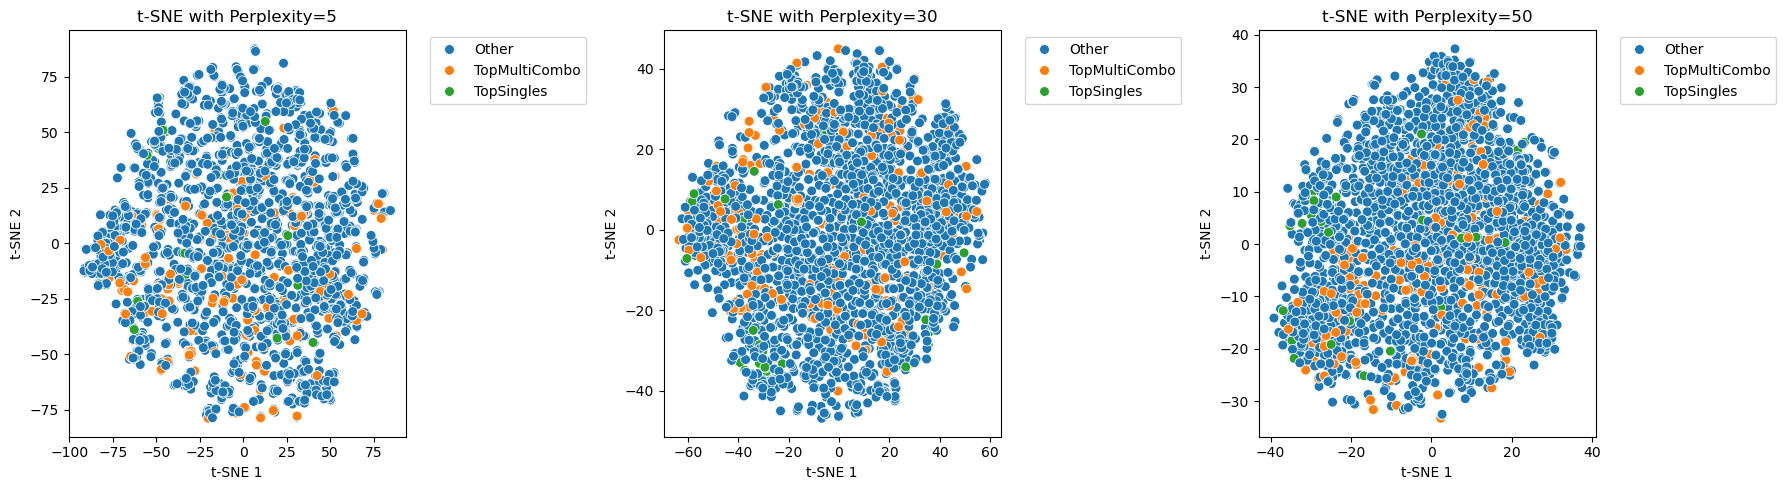

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Assume X_scaled is your standardized feature matrix
perplexities = [5, 30, 50]

plt.figure(figsize=(18,5))

for i, perp in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42, n_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)
    
    plt.subplot(1, len(perplexities), i+1)
    sns.scatterplot(
        x=X_tsne[:,0],
        y=X_tsne[:,1],
        hue=Y_["viz_category"], 
        palette="tab10",
        s=50
    )
    plt.title(f"t-SNE with Perplexity={perp}")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

Choice of Perplexity Hyperparameter:

1.**Perplexity = 5**

From the first plot, it can be seen that the points are highly scattered across the plane, with many small micro-clusters. Orange (TopMultiCombo) and green (0) are spread randomly, often isolated, and not forming coherent groups. Blue (Other) dominates and is scattered everywhere.


Local structure is preserved too strongly because each point considers only a very small neighborhood. But the Global structure is lost the embedding looks noisy and disorganized.

 It overemphasizes local patterns, leading to a fragmented view that hides overall relationships.

2. **Perplexity = 30** 

The second plot is much cleaner and have denser cluster structure.

Orange (TopMultiCombo) points are grouped more clearly, especially on the left and upper regions. Green (0) points appear in small, interpretable patches. Blue (Other) forms the majority cloud, but now with smoother distribution.


Local structure is well-preserved as orange and green clusters are still visible. Here the global structure is better captured, the embedding forms a single coherent blob instead of many fragments. Outliers are reduced, making the visualization more interpretable.

 This gives the best balance as both local clusters and global shape are visible.

3. **Perplexity = 50**

In the third plot, the points are very tightly packed, forming a single dense oval shape. Orange and green points are still present but more spread inside the blue cluster, losing separation.

Local structure is partly lost as orange and green are blended into blue regions instead of forming distinct patches. Global structure is preserved strongly. The overall dataset looks like one unified shape.

It emphasizes global similarity at the cost of local distinctions.

**So the final Choice is Perplexity = 30.**
At 5, the embedding is too noisy and fragmented.
At 50, the embedding oversmooths and hides smaller structures.

At 30, Orange (TopMultiCombo) and green (0) show up as distinct local clusters while still embedded in the global shape. Blue (Other) dominates but doesn’t completely swallow the others.

Both local neighborhoods and global geometry are balanced.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


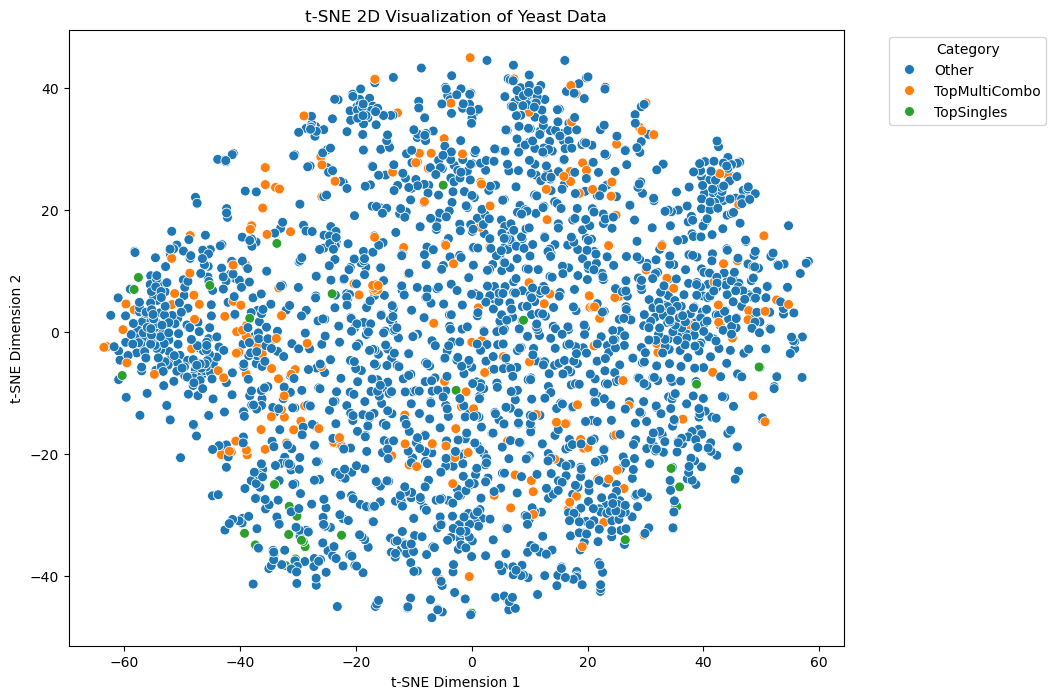

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Choose final perplexity (for example, 30)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# 2D Scatter Plot
plt.figure(figsize=(10,8))
sns.scatterplot(
    x=X_tsne[:,0],
    y=X_tsne[:,1],
    hue=Y_["viz_category"],  
    palette="tab10",
    s=50
)
plt.title("t-SNE 2D Visualization of Yeast Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

#### Veracity Inspection 

1. Noisy / Ambiguous Labels

In the plot, at the extreme left there are blue points deeply embedded in a cluster and orange points could be considered as noise. Similarly at the top and right also blue clusters are seen with orange points as noise.

The orange points sprinkled inside dense blue regions, and occasionally a few green points stuck inside an orange cluster.
These can be considered as noise.

2. Outliers

The edges of the embedding, especially bottom-left and top, there are single green or orange  and even some blue dots far away from any dense cluster.

Outliers could represent rare biological conditions, unusual combinations of features, or even experimental noise / recording error.

In ML terms, they may have low predictive power but high influence on distance-based algorithms.


3. Hard-to-Learn Samples

In the central region of the plot, blue (Other), green (0), and orange (TopMultiCombo) are thoroughly intermixed, with no clean boundaries.

A simple linear classifier (like logistic regression) would struggle badly here because no single linear boundary can separate the overlapping classes.
Even non-linear methods (like decision trees) might misclassify unless they capture very fine-grained rules.

These are inherently difficult samples. They either reflect genuine overlap in functional categories or insufficient features to fully discriminate.


The embedding shows noisy labels (points embedded in the wrong-colored clusters), outliers (isolated samples at the edges), and hard-to-learn regions (central areas of color mixing), all of which highlight that the real-world datasets rarely form clean clusters and hence classifiers face challenges.

### Part C: Isomap and Manifold Learning

Conceptual Difference between t-SNE and Isomap

t-SNE captures **Local Structure**.

It focuses on preserving local neighborhoods. It tries to optimize similarity probabilities between points.It is great for visualizing clusters, but distances between clusters are not necessarily meaningful.

Isomap captures **Global Structure**.

It builds a neighborhood graph and computes geodesic distances (shortest paths along the manifold), hence it preserves global geometry of the data.
It is great for unfolding nonlinear manifolds like the "Swiss roll" example.

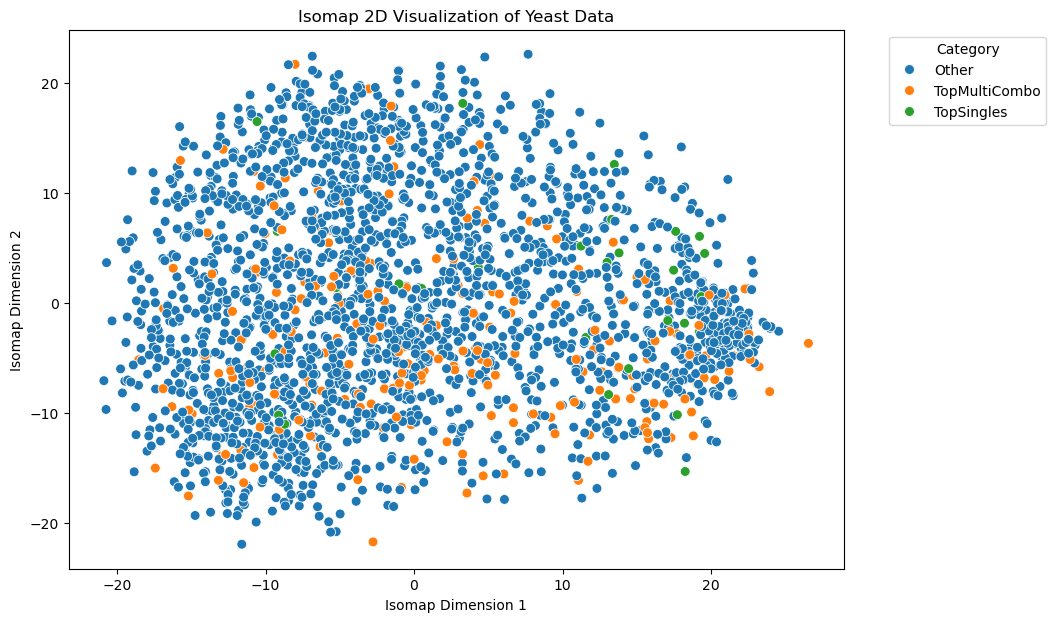

In [16]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import seaborn as sns

# Applying Isomap to scaled data
isomap = Isomap(n_neighbors=10, n_components=2)  
X_isomap = isomap.fit_transform(X_scaled)


# 2D Scatter Plot
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=X_isomap[:,0],
    y=X_isomap[:,1],
    hue=Y_["viz_category"],   
    palette="tab10",
    s=50
)
plt.title("Isomap 2D Visualization of Yeast Data")
plt.xlabel("Isomap Dimension 1")
plt.ylabel("Isomap Dimension 2")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


#### Comparison and Curvature 

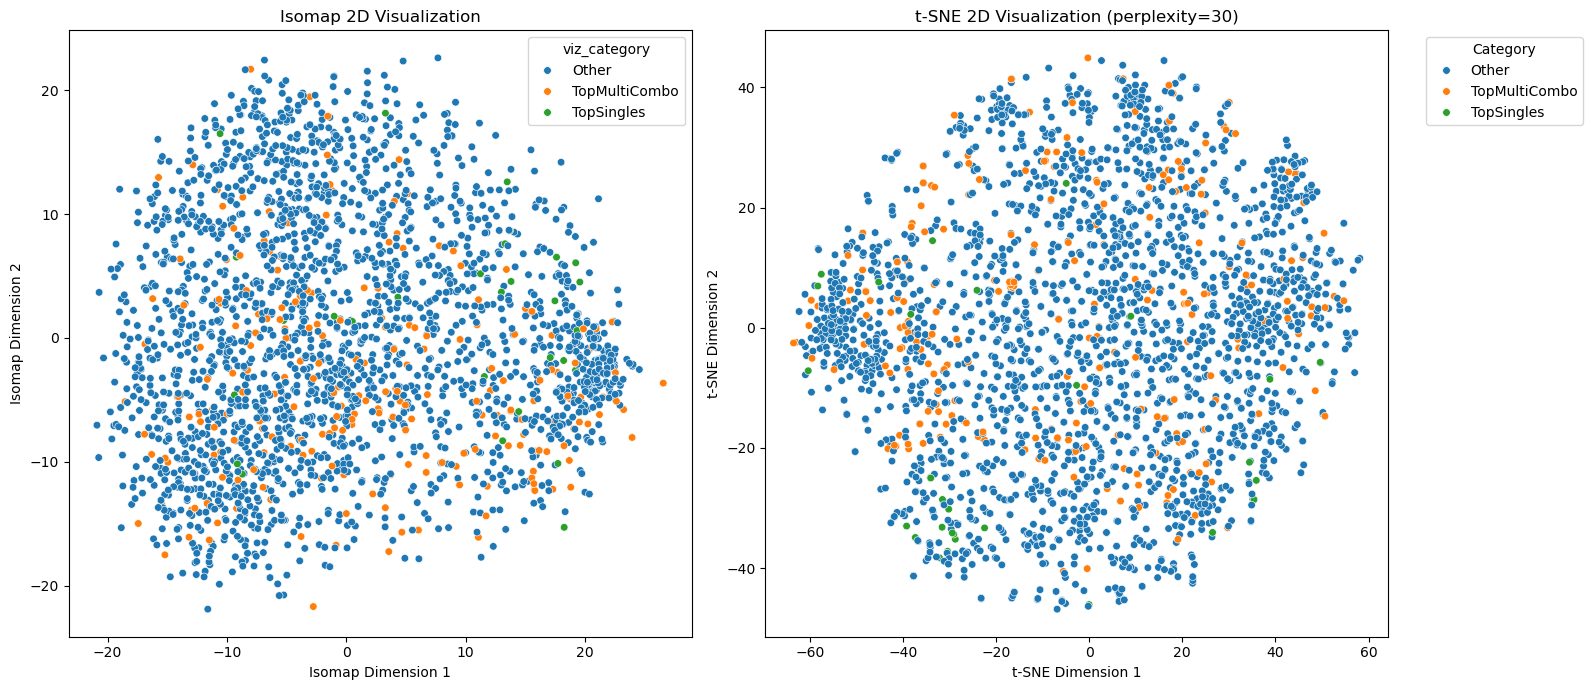

In [17]:
from sklearn.manifold import Isomap, TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Run Isomap 
isomap = Isomap(n_neighbors=10, n_components=2)  
X_isomap = isomap.fit_transform(X_scaled)

# Run t-SNE with perplexity=30
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Side-by-side plots 
fig, axes = plt.subplots(1, 2, figsize=(16,7))

# Isomap
sns.scatterplot(
    x=X_isomap[:,0],
    y=X_isomap[:,1],
    hue=Y_["viz_category"],
    palette="tab10",
    s=30,
    ax=axes[0]
)
axes[0].set_title("Isomap 2D Visualization")
axes[0].set_xlabel("Isomap Dimension 1")
axes[0].set_ylabel("Isomap Dimension 2")

# t-SNE
sns.scatterplot(
    x=X_tsne[:,0],
    y=X_tsne[:,1],
    hue=Y_["viz_category"],
    palette="tab10",
    s=30,
    ax=axes[1]
)
axes[1].set_title("t-SNE 2D Visualization (perplexity=30)")
axes[1].set_xlabel("t-SNE Dimension 1")
axes[1].set_ylabel("t-SNE Dimension 2")

# Put legend outside
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Isomap (left plot): Preserves global structure. It tries to keep the manifold’s overall shape consistent with geodesic distances. The result is a fairly continuous spread of points as compared to t-SNE(it has more tiny blue clusters, with less artificial gaps and no over-separated clusters.

Good at showing the "big map" of how all samples relate globally.

t-SNE (right plot): Emphasizes local neighborhood structure — groups nearby points tightly together. There are more apparent cluster-like formations, but the distances between clusters are not trustworthy (t-SNE can “invent” spacing).

It distorts the global picture. Clusters look more separated than they actually are in high-dimensional space.

Isomap is better at revealing the global structure of gene expression data, since it retains the overall manifold geometry.
t-SNE is better for local separation (seeing which samples cluster together), but misleads about global relationships.

**Data manifold & curvature:**

Concept of a data manifold:
In high-dimensional datasets like gene expression, data often lies near a lower-dimensional surface (manifold) rather than filling the whole high-D space. Nonlinear dimensionality reduction methods (Isomap, t-SNE) try to uncover this intrinsic manifold.

The Isomap plot shows a continuous, moderately folded surface with lots of overlap between categoriesIt is not a simple flat/linear manifold (otherwise PCA would suffice), but also not an extremely twisted or disjoint Swiss roll. So, the manifold is moderately curved and somewhat complex.

**Relation to classification difficulty:**

Because categories (orange, green, blue) overlap within the same manifold regions, the separation boundaries are nonlinear. This makes classification harder for linear models, since the decision surface must follow the manifold folds. Complex manifolds usually require nonlinear classifiers (kernel SVM, neural nets, boosted trees). If the manifold is highly tangled, classification accuracy has a natural ceiling due to intrinsic class overlap.

The Isomap plot suggests a nonlinear, moderately curved manifold. This complexity increases classification difficulty, since classes are mixed across the surface and require nonlinear methods to separate.